# Irir Classifier

In [1]:
from sklearn.datasets import load_iris
import pennylane as qml
import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Prepare Datasets

In [3]:
X, Y = load_iris(return_X_y=True)

X_train_0 = X[0:30]
X_train_1 = X[50:80]
X_train = np.vstack((X_train_0, X_train_1))

Y_train_0 = Y[0:30]
Y_train_1 = Y[50:80]
Y_train = np.vstack((Y_train_0, Y_train_1)).flatten()

X, Y = load_iris(return_X_y=True)

X_test_0 = X[30:50]
X_test_1 = X[80:100]
X_test = np.vstack((X_test_0, X_test_1))

Y_test_0 = Y[30:50]
Y_test_1 = Y[80:100]
Y_test = np.vstack((Y_test_0, Y_test_1)).flatten()

In [4]:
X_train = (X_train - X_train.min(axis=0)) / (X_train.max(axis=0) - X_train.min(axis=0))
X_test = (X_test - X_test.min(axis=0)) / (X_test.max(axis=0) - X_test.min(axis=0))

## Init Variational Quantum Classifier

In [5]:
qubits_num = 4
layers_num = 2

dev = qml.device("default.qubit", wires=qubits_num)

In [41]:
class VQC:
    def __init__(self):
        # 3 => U3(theta, phi, lambda)
        self.params = (0.1 * np.random.randn(layers_num, qubits_num, 3))
        self.bestparams = self.params
        self.bestcost = 10
        
        self.opt = AdamOptimizer(0.125)
        
        self.weights = []
        self.costs = []
        self.accuracies = []
        
    def fit(self, X_train, Y_train, epoch=300):
        batch_size = 20

        for turn in range(epoch):
            # Update the weights by one optimizer step
            batch_index = np.random.randint(0, len(X_train), (batch_size,))
            X_train_batch = X_train[batch_index]
            Y_train_batch = Y_train[batch_index]
            self.params = self.opt.step(lambda v: cost(v, X_train_batch, Y_train_batch), self.params)

            cost_now = cost(self.params, X_train, Y_train)
            acc_now = accuracy(self.params, X_train, Y_train) 

            if cost_now < self.bestcost:
                self.bestcost = cost_now
                self.bestparams = self.params
            
            self.weights.append(self.params)
            self.costs.append(cost_now)
            self.accuracies.append(acc_now)
            
            print(
                "Turn: {:5d} | Cost: {:0.7f} | Accuracy: {:0.2f}% ".format(
                turn, cost_now, acc_now * 100
            ))
            
    def score(self, X_test, Y_test):
        predictions = [ predict(self.bestparams, data) for data in X_test ]
        acc = accuracy(self.bestparams, X_test, Y_test)
        
        print("FINAL ACCURACY: {:0.2f}%".format(acc * 100))

In [42]:
@qml.qnode(dev)
def circuit(params, data):
    angles = [ i  * np.pi for i in data ]

    for i in range(qubits_num):
        qml.RX(angles[i], wires=i)
        qml.Rot( *params[0, i], wires=i )

    qml.CZ(wires=[1, 0])
    qml.CZ(wires=[1, 2])
    qml.CZ(wires=[2, 3])
    qml.CZ(wires=[0, 3])

    for i in range(qubits_num):
        qml.Rot( *params[1, i], wires=i )
    
    # PauliZ measure => 1 -> |0>  while -1 -> |1>
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3))

### - cost function in VQC

In [43]:
def cost(weights, datas, labels):
    loss = 0
    
    for i, data in enumerate(datas):
        # like [-1, 1, 1]
        measured = circuit(weights, data)

        p = measured[0]
        if labels[i] == 0:
            loss += (1 - p) ** 2
        else:
            loss += (-1 - p) ** 2
            
        
    return loss / len(datas)

### - predict in VQC

In [44]:
import qiskit
import numpy as np
from qiskit import QuantumCircuit
from qiskit import Aer, execute

unitary_backend = Aer.get_backend('unitary_simulator')
qasm_backend = Aer.get_backend('qasm_simulator')

In [45]:
def predict(params, data):
    qcircuit = QuantumCircuit(4, 4)
    qubits = qcircuit.qubits

    for i, d in enumerate(data):
        qcircuit.rx(d * np.pi, qubits[i])
        
    for i in range(qubits_num):
        qcircuit.u3(*params[0][i], qubits[i])

    qcircuit.cz(qubits[0], qubits[1])
    qcircuit.cz(qubits[1], qubits[2])
    qcircuit.cz(qubits[2], qubits[3])
    qcircuit.cz(qubits[0], qubits[3])

    for i in range(qubits_num):
        qcircuit.u3(*params[1][i], qubits[i])
    
    # the measurement
    qcircuit.measure([0, 1, 2, 3], [0, 1, 2, 3])

    # job execution
    shots = 1000
    job_sim = execute(qcircuit, qasm_backend, shots=shots)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qcircuit)

    p1 = (counts.get('1000', 0) + counts.get('1001', 0) + counts.get('1010', 0) + counts.get('1011',0) + \
         counts.get('1100', 0) + counts.get('1101', 0) + counts.get('1110', 0) + counts.get('1111', 0)) / shots
    
    if p1 > 0.5:
        return 1
    else:
        return 0

### - accuracy scoring in VQC

In [46]:
def accuracy(weights, datas, labels):
    predictions = [ predict(weights, data) for data in datas ]
    
    acc = 0
    for i, p in enumerate(predictions):
        if p == labels[i]:
            acc += 1
    
    return acc / len(predictions)

## Train VQC

In [47]:
vqc = VQC()

In [49]:
vqc.fit(X_train, Y_train, epoch=10)

Turn:     0 | Cost: 0.4360805 | Accuracy: 100.00% 
Turn:     1 | Cost: 0.4360805 | Accuracy: 100.00% 
Turn:     2 | Cost: 0.4360805 | Accuracy: 100.00% 
Turn:     3 | Cost: 0.4360805 | Accuracy: 100.00% 
Turn:     4 | Cost: 0.4360805 | Accuracy: 100.00% 
Turn:     5 | Cost: 0.4360805 | Accuracy: 100.00% 
Turn:     6 | Cost: 0.4360805 | Accuracy: 100.00% 
Turn:     7 | Cost: 0.4360805 | Accuracy: 100.00% 
Turn:     8 | Cost: 0.4360805 | Accuracy: 100.00% 
Turn:     9 | Cost: 0.4360805 | Accuracy: 100.00% 


In [50]:
vqc.score(X_test, Y_test)

FINAL ACCURACY: 100.00%


In [51]:
vqc.bestparams

array([[[ 0.01351579,  0.09796321, -0.0787506 ],
        [ 0.0247594 , -0.05314529, -0.01688076],
        [ 0.0036963 ,  0.00189247,  0.05882401],
        [ 0.12001614, -0.04561222, -0.1758587 ]],

       [[ 0.07195059, -0.14918295,  0.17647329],
        [-0.03588413, -0.14007738, -0.03474859],
        [-0.00693093,  0.05308237,  0.26818109],
        [ 0.09667641, -0.13599804,  0.06117493]]])

## Create Corresponding Circuit

In [52]:
def createCircuit(params, data):
    qcircuit = QuantumCircuit(4, 4)
    qubits = qcircuit.qubits

    for i, d in enumerate(data):
        qcircuit.rx(d * np.pi, qubits[i])

    for i in range(qubits_num):
        qcircuit.u3(*params[0][i], qubits[i])

    qcircuit.cz(qubits[0], qubits[1])
    qcircuit.cz(qubits[1], qubits[2])
    qcircuit.cz(qubits[2], qubits[3])
    qcircuit.cz(qubits[0], qubits[3])

    for i in range(qubits_num):
        qcircuit.u3(*params[1][i], qubits[i])
        
    return qcircuit

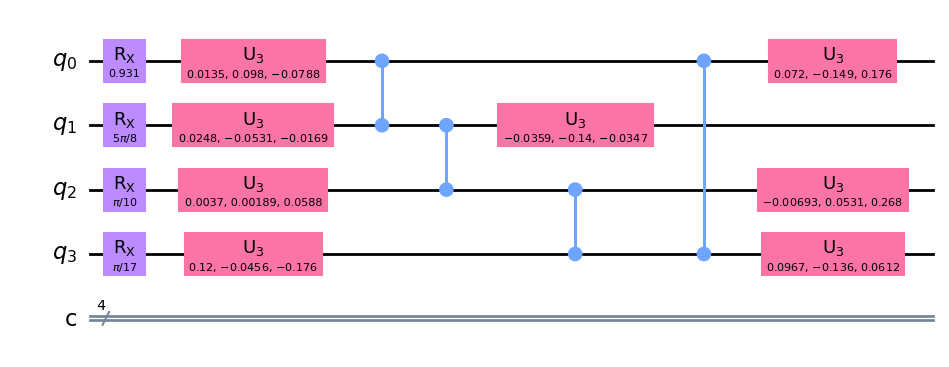

In [53]:
qcircuit = createCircuit(vqc.bestparams, X_train[0])
qcircuit.draw(output='mpl')